In [29]:
import sys
sys.path.insert(0, "/home/tfioratti/git/stockora/")
from stockora.shadow_clone import parallelize

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def dsigmoid_from_val(s):
    return s * (1.0 - s)

def dtanh_from_val(t):
    return 1.0 - t*t

def make_Us(N, g=1.0, seed_J=0):
    rng = np.random.RandomState(seed_J)
    scale = g / np.sqrt(N)
    U_i = scale * rng.randn(N, N)
    U_f = scale * rng.randn(N, N)
    U_o = scale * rng.randn(N, N)
    U_g = scale * rng.randn(N, N)
    return U_i, U_f, U_o, U_g

def make_biases(N, sigma_b=0.0, seed_b=1):
    rng = np.random.RandomState(seed_b)
    b_i = sigma_b * rng.randn(N)
    b_f = sigma_b * rng.randn(N)
    b_o = sigma_b * rng.randn(N)
    b_g = sigma_b * rng.randn(N)
    return b_i, b_f, b_o, b_g

def make_h0c0(N, scale_h=0.1, scale_c=0.1, seed=2):
    rng = np.random.RandomState(seed)
    h0 = scale_h * rng.randn(N)
    c0 = scale_c * rng.randn(N)
    return h0, c0

def make_v0(N, seed=3):
    rng = np.random.RandomState(seed)
    dh = rng.randn(N)
    dc = rng.randn(N)
    v  = np.concatenate([dh, dc])
    return v / (np.linalg.norm(v) + 1e-32)

def lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g):
    z_i = U_i @ h + b_i
    z_f = U_f @ h + b_f
    z_o = U_o @ h + b_o
    z_g = U_g @ h + b_g

    i = sigmoid(z_i)
    f = sigmoid(z_f)
    o = sigmoid(z_o)
    g = np.tanh(z_g)

    c_new = f * c + i * g
    h_new = o * np.tanh(c_new)

    cache = {"i": i, "f": f, "o": o, "g": g, "c_prev": c, "c": c_new}
    return h_new, c_new, cache

def lstm_tangent_jvp(dh, dc, cache, U_i, U_f, U_o, U_g):
    i = cache["i"]; f = cache["f"]; o = cache["o"]; g = cache["g"]
    c_prev = cache["c_prev"]; c = cache["c"]

    di = dsigmoid_from_val(i) * (U_i @ dh)
    df = dsigmoid_from_val(f) * (U_f @ dh)
    do = dsigmoid_from_val(o) * (U_o @ dh)
    dg = dtanh_from_val(g)     * (U_g @ dh)

    dc_new = df * c_prev + f * dc + di * g + i * dg
    tanh_c = np.tanh(c)
    dh_new = do * tanh_c + o * dtanh_from_val(tanh_c) * dc_new
    return dh_new, dc_new

def compute_trajectory_lstm(Us, bs, g, dt, T, warmup, h0, c0, record_stride=1):
    
    steps_warm = int(np.round(warmup / dt))
    steps_sim  = int(np.round(T / dt))
    U_i, U_f, U_o, U_g = Us
    b_i, b_f, b_o, b_g = bs

    h = h0.copy(); c = c0.copy(); t = 0.0
    for _ in range(steps_warm):
        h, c, _ = lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g)
        t += dt

    S  = steps_sim // record_stride
    Hs = np.empty((S, h.size))
    Cs = np.empty((S, c.size))
    ts = np.empty(S)
    k  = 0
    for s in range(steps_sim):
        h, c, _ = lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g)
        t += dt
        if (s + 1) % record_stride == 0:
            Hs[k] = h; Cs[k] = c; ts[k] = t; k += 1
    return Hs, Cs, ts


def compute_lyapunov_lstm(Us, bs, g, dt, T, warmup, h0, c0, v0,
                          reorth_every=10, eps0=1e-7):
  
    steps_warm = int(np.round(warmup / dt))
    steps      = int(np.round(T / dt))
    U_i, U_f, U_o, U_g = Us
    b_i, b_f, b_o, b_g = bs

    h = h0.copy(); c = c0.copy()
    for _ in range(steps_warm):
        h, c, _ = lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g)

    N = h.size
    dh = v0[:N].copy()
    dc = v0[N:].copy()
    n0 = np.sqrt(np.linalg.norm(dh)**2 + np.linalg.norm(dc)**2) + 1e-32
    dh *= (eps0 / n0); dc *= (eps0 / n0)

    accum = 0.0
    count = 0

    for s in range(steps):
        h, c, cache = lstm_step(h, c, U_i, U_f, U_o, U_g, b_i, b_f, b_o, b_g)
        dh, dc = lstm_tangent_jvp(dh, dc, cache, U_i, U_f, U_o, U_g)

        if (s + 1) % reorth_every == 0:
            norm_v = np.sqrt(np.linalg.norm(dh)**2 + np.linalg.norm(dc)**2) + 1e-32
            accum += np.log(norm_v / eps0)
            count += 1
            dh *= (eps0 / norm_v)
            dc *= (eps0 / norm_v)

    return (accum / (count * reorth_every)) / dt if count > 0 else float('nan')

def plot_traces(ts, Hs, max_traces=5, title=None):
    idx = np.arange(min(max_traces, Hs.shape[1]))
    plt.figure(figsize=(8,4.5))
    for i in idx:
        plt.plot(ts, Hs[:, i], label=f"h[{i}]")
    plt.xlabel("time"); plt.ylabel("h_t")
    if title: plt.title(title)
    plt.grid(True, alpha=0.3)
    if len(idx) <= 10: plt.legend()
    plt.show()

def plot_lyapunov(g_vals, lam_vals, title=None):
    plt.figure(figsize=(8,4.5))
    plt.plot(g_vals, lam_vals, marker="o")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("g")
    plt.ylabel("Largest Lyapunov exponent (1/time)")
    if title: plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()



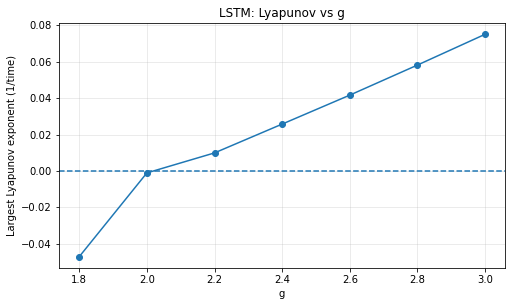

In [34]:
  # setup
N = 4000; dt = 1
T = 2000.0; warmup = 250.0
g_vals = np.linspace(1.8, 3.0, 7)

Us = make_Us(N, g=1.0, seed_J=9)          
bs = make_biases(N, sigma_b=0, seed_b=1) 
h0, c0 = make_h0c0(N, scale_h=1, scale_c=1, seed=2)
v0 = make_v0(N, seed=3)


lam_vals = []
for g in g_vals:
    Us_g = tuple(g * U for U in Us)
    lam = compute_lyapunov_lstm(Us_g, bs, g, dt, T, warmup, h0, c0, v0,
                                reorth_every=10, eps0=1e-7)
    lam_vals.append(lam)
plot_lyapunov(g_vals, lam_vals, title="LSTM: Lyapunov vs g")




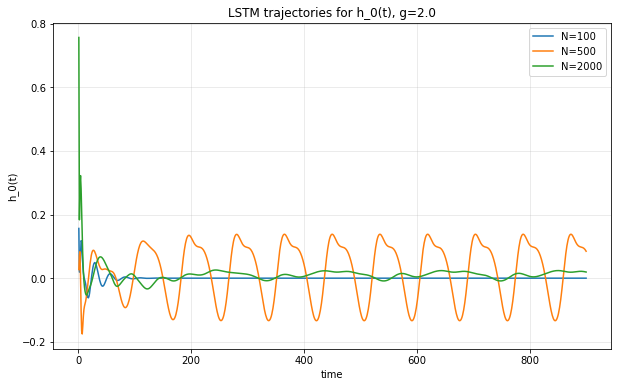

In [42]:
  # setup
T = 500; warmup = 100
N_dim = [100, 500, 2000]
dt = 1
g_demo = 2.0

plt.figure(figsize=(10, 6))

for N in N_dim:
    Us = make_Us(N, g=1.0, seed_J=6)          
    bs = make_biases(N, sigma_b=0.0, seed_b=1) 
    h0, c0 = make_h0c0(N, scale_h=1, scale_c=1, seed=2)
    v0 = make_v0(N, seed=3)
    Us_demo = tuple((g_demo/1.0) * U for U in Us)

    Hs, Cs, ts = compute_trajectory_lstm(
        Us_demo, bs, g_demo, dt,
        T=900.0, warmup=0,
        h0=h0, c0=c0,
        record_stride=1
    )

    plt.plot(ts, Hs[:, 0], label=f"N={N}")

plt.xlabel("time")
plt.ylabel("h_0(t)")
plt.title(f"LSTM trajectories for h_0(t), g={g_demo}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [70]:
def _split_seeds(seed_J: int):
    base = int(seed_J) & 0xFFFFFFFF
    return {
        'seed_x0': (base + 1) & 0xFFFFFFFF,
        'seed_v0': (base + 2) & 0xFFFFFFFF,
        'seed_b':  (base + 3) & 0xFFFFFFFF,
    }

def find_gc_job_lstm(job, *, N, dt, T, warmup,
                     g_lo=1.7, g_hi=4.0, tol=1e-3, max_iter=20):
    
    sigma_b = float(job['sigma_b'])
    seed_J  = int(job['seed_J'])

    seeds = _split_seeds(seed_J)


    Us_base = make_Us(N, g=1.0, seed_J=seed_J)


    h0, c0 = make_h0c0(N, scale_h=1e-4, scale_c=1e-4, seed=seeds['seed_x0'])
    v0     = make_v0(N, seed=seeds['seed_v0'])
    bs     = make_biases(N, sigma_b=sigma_b, seed_b=seeds['seed_b'])

    def Us_scaled(g):
        return tuple(g * U for U in Us_base)

    lam_lo = compute_lyapunov_lstm(Us_scaled(g_lo), bs, g_lo, dt, T, warmup, h0, c0, v0,
                                   reorth_every=10, eps0=1e-7)
    lam_hi = compute_lyapunov_lstm(Us_scaled(g_hi), bs, g_hi, dt, T, warmup, h0, c0, v0,
                                   reorth_every=10, eps0=1e-7)

    if lam_lo >= 0:
        gc = g_lo
    elif lam_hi <= 0:
        gc = float('nan')
    else:
        lo, hi = g_lo, g_hi
        for _ in range(max_iter):
            mid = 0.5 * (lo + hi)
            lam = compute_lyapunov_lstm(Us_scaled(mid), bs, mid, dt, T, warmup, h0, c0, v0,
                                        reorth_every=10, eps0=1e-7)
            if lam > 0:
                hi = mid
            else:
                lo = mid
            if hi - lo < tol:
                break
        gc = 0.5 * (lo + hi)

    return {'seed_J': seed_J, 'sigma_b': sigma_b, 'g_c': float(gc)}


In [71]:
N = 1000; dt = 1
T = 1000.0; warmup = 100.0
sigma_grid   = np.linspace(0, 0.5, 20)
seed_J_list  = list(range(40))  

In [72]:

jobs = [{'seed_J': int(sJ), 'sigma_b': float(s)}
        for sJ in seed_J_list
        for s in sigma_grid]

results = parallelize(
    exec_func=find_gc_job_lstm,   
    jobs=jobs,
    single_arg=True,
    exec_kwargs=dict(
        N=N, dt=dt, T=T, warmup=warmup,
        g_lo=1.7, g_hi=3.0, tol=1e-3, max_iter=20
    ),
    mode="slurm",
    wait_for_graph_execution=False,
    root_dir="/mnt/live/user/tfioratti/gc_parallel_J_sigma_lstm",
)


Graph tfioratti__gc_parallel_J_sigma_lstm posted. Follow the execution using the [grid view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/manage/tfioratti__gc_parallel_J_sigma_lstm) or the [graph view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/display/tfioratti__gc_parallel_J_sigma_lstm)

In [73]:
import json
from pathlib import Path
results_dir = Path("/mnt/live/user/tfioratti/gc_parallel_J_sigma_lstm/execution_results")

data_dict = {}

for result_file in results_dir.glob("*.json"):  
    with open(result_file, 'r') as file:
        data = json.load(file)
    tau_value = data  
    file_key = result_file.stem
    data_dict[file_key] = tau_value


In [74]:
seeds = sorted({v['seed_J'] for v in data_dict.values()})
sigma_b_values = sorted({v['sigma_b'] for v in data_dict.values()})


seed_index = {seed: i for i, seed in enumerate(seeds)}
sigma_b_index = {sigma: i for i, sigma in enumerate(sigma_b_values)}

# Crea un array per i valori di g_c
g_c_array = np.empty((len(seeds), len(sigma_b_values)))
g_c_array.fill(np.nan) 


for item in data_dict.values():
    seed = item['seed_J']
    sigma_b = item['sigma_b']
    g_c = item['g_c']
    i = seed_index[seed]
    j = sigma_b_index[sigma_b]
    g_c_array[i, j] = g_c

g_c_empirical = np.mean(g_c_array, axis = 0)
print(g_c_empirical)
err = np.std(g_c_array, axis = 0)/np.sqrt(len(seed_J_list))

[2.01159058 2.14201904 2.17485229 2.20584473 2.22583984 2.25075439
 2.27823975 2.30931152 2.32251465 2.33249634 2.3440332  2.35785522
 2.37734253 2.38681641 2.40022583 2.41328613 2.42539429 2.42758423
 2.44283447 2.44975342]


<ErrorbarContainer object of 3 artists>

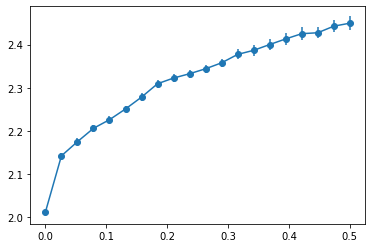

In [75]:
plt.errorbar(sigma_b_values, g_c_empirical, yerr = err, marker = 'o', label='Simulation', markersize=6)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7.5,5))
plt.errorbar(sigma_b_values, g_c_empirical, yerr = err, marker = 'o', label='Simulation', markersize=6)
plt.xlabel(r"Bias amplitude $\sigma_I$ (fixed direction, per-neuron std)")
plt.ylabel(r"Critical gain $g_c$")
plt.title(r"$g_c$ vs $\sigma_I$")
plt.grid(True, alpha=0.3)
plt.show()

In [76]:
np.savez('full.npz', sigma_b=sigma_b_values, g_c=g_c_empirical, error=err)